# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [0]:
# using SQLite Table to read data.
con = sqlite3.connect('/content/drive/My Drive/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [0]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [0]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 364171/364171 [02:27<00:00, 2474.08it/s]


In [0]:
preprocessed_reviews[1500]

'great ingredients although chicken rather chicken broth thing not think belongs canola oil canola rapeseed not someting dog would ever find nature find rapeseed nature eat would poison today food industries convinced masses canola oil safe even better oil olive virgin coconut facts though say otherwise late poisonous figured way fix still like could better'

In [0]:
final['clean_rev']=preprocessed_reviews
#final.head(1)
final=final[:100000]

# [4] Featurization

## TF-IDF

# [5] Assignment 11: Truncated SVD

<ol>
    <li><strong>Apply Truncated-SVD on only this feature set:</strong>
        <ul>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
    <br>
    <li><strong>Procedure:</strong>
        <ul>
    <li>Take top 2000 or 3000 features from tf-idf vectorizers using idf_ score.</li>
    <li>You need to calculate the co-occurrence matrix with the selected features (Note: X.X^T
doesn’t give the co-occurrence matrix, it returns the covariance matrix, check these
        bolgs <a href='https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285'>blog-1,</a> <a href='https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/'>blog-2 </a>for more information)</li>
            <li>You should choose the n_components in truncated svd, with maximum explained
variance. Please search on how to choose that and implement them. (hint: plot of
cumulative explained variance ratio)</li>
            <li>After you are done with the truncated svd, you can apply K-Means clustering and choose
the best number of clusters based on elbow method.</li>
            <li> Print out wordclouds for each cluster, similar to that in previous assignment. </li>
            <li>You need to write a function that takes a word and returns the most similar words using
cosine similarity between the vectors(vector: a row in the matrix after truncatedSVD)</li>
        </ul>
    </li>
    <br>
    
</ol>

## Truncated-SVD

### [5.1] Taking top features from TFIDF,<font color='red'> SET 2</font>

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,1), max_features=2000)
tf_idf_vect.fit(final['clean_rev'].values)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(final['clean_rev'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['able', 'absolute', 'absolutely', 'according', 'acid', 'across', 'active', 'actual', 'actually', 'add']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (100000, 2000)
the number of unique words including both unigrams and bigrams  2000


### [5.2] Calculation of Co-occurrence matrix

In [0]:
# Source:- http://www.foldl.me/2014/glove-python/
def build_cooccur(vocab, corpus, window_size=5):
    vocab_size = len(vocab)
    #id2word = dict((i, word) for word, (i, _) in vocab.iteritems())

    # Collect cooccurrences internally as a sparse matrix for
    # passable indexing speed; we'll convert into a list later
    cooccurrences = sparse.lil_matrix((vocab_size, vocab_size),
                                      dtype=np.float64)
    word_list = tf_idf_vect.get_feature_names()
    for idx, line in (enumerate(corpus)):
        
        tokens = line.strip().split()
        token_ids = [vocab[word] for word in tokens if word in word_list]
        
        for center_i, center_id in enumerate(token_ids):
            # Collect all word IDs in left window of center word            
            context_ids = token_ids[max(0, center_i - window_size)
                                    : center_i]
            contexts_len = len(context_ids)            
            
            for left_i, left_id in enumerate(context_ids):                
                distance = contexts_len - left_i
                # Weight by inverse of distance between words
                increment = 1.0 / float(distance)

                # Build co-occurrence matrix symmetrically (pretend
                # we are calculating right contexts as well)
                cooccurrences[center_id, left_id] += increment
                cooccurrences[left_id, center_id] += increment
                
        if(idx!=0 and idx%10000==0) :
                    print('done with {} iterations'.format(idx))
        
        cooccurrences.setdiag(1.00) # word co-occurrence with itself is maximum (1.00)
    
    return cooccurrences

In [0]:
cooccur_matrix = build_cooccur(tf_idf_vect.vocabulary_, final['clean_rev'].values,window_size=5)

done with 10000 iterations
done with 20000 iterations
done with 30000 iterations
done with 40000 iterations
done with 50000 iterations
done with 60000 iterations
done with 70000 iterations
done with 80000 iterations
done with 90000 iterations


### [5.3] Finding optimal value for number of components (n) to be retained.

done for dimensions  10
done for dimensions  20
done for dimensions  30
done for dimensions  40
done for dimensions  50
done for dimensions  60
done for dimensions  70
done for dimensions  80
done for dimensions  90
done for dimensions  100
done for dimensions  110
done for dimensions  120
done for dimensions  130
done for dimensions  140


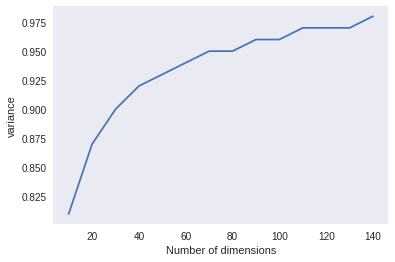

maximum variance for dimension 140


In [0]:
from sklearn.decomposition import TruncatedSVD

X = cooccur_matrix

dims = range(10,150,10)

variance_sum=[]

for dim in dims:
    
    svd=TruncatedSVD(n_components = dim)
    svd.fit(X)
    variance_sum.append(round(svd.explained_variance_ratio_.sum(),2))
    print('done for dimensions ',str(dim))

plt.plot(dims, variance_sum)
plt.xlabel('Number of dimensions')
plt.ylabel('variance')
plt.grid()
plt.show()        

print('maximum variance for dimension',dims[variance_sum.index(max(variance_sum))])
svd = TruncatedSVD(n_components = dims[variance_sum.index(max(variance_sum))])
X=svd.fit_transform(X)

In [0]:
np.save('reduced_dimension_matrix',X)
X = np.load('reduced_dimension_matrix.npy')

### [5.4] Applying k-means clustering

done for num of clusters 2
done for num of clusters 3
done for num of clusters 4
done for num of clusters 5
done for num of clusters 6
done for num of clusters 7
done for num of clusters 8
done for num of clusters 9
done for num of clusters 10
done for num of clusters 11
done for num of clusters 12
done for num of clusters 13
done for num of clusters 14
done for num of clusters 15
done for num of clusters 16
done for num of clusters 17
done for num of clusters 18
done for num of clusters 19


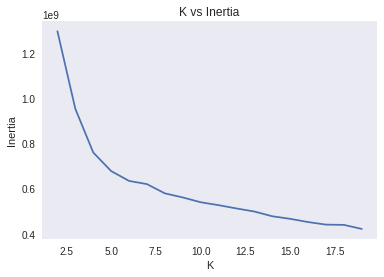

In [0]:
from sklearn.cluster import KMeans
inertia = []
for k in (range(2,20)):
    kmeans = KMeans(n_clusters=k,n_jobs=-1).fit(X)
    inertia.append(kmeans.inertia_)
    print('done for num of clusters',str(k))
plt.plot(range(2,20),inertia,label='k vs inertia')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.title('K vs Inertia')
plt.grid()
plt.show()

In [0]:
# it seems elbow point is at k=5
kmeans = KMeans(n_clusters=5,n_jobs=-1).fit(X)

In [0]:
df=pd.DataFrame({'words':tf_idf_vect.get_feature_names(),'cluster':kmeans.labels_})
df2=df.groupby('cluster')

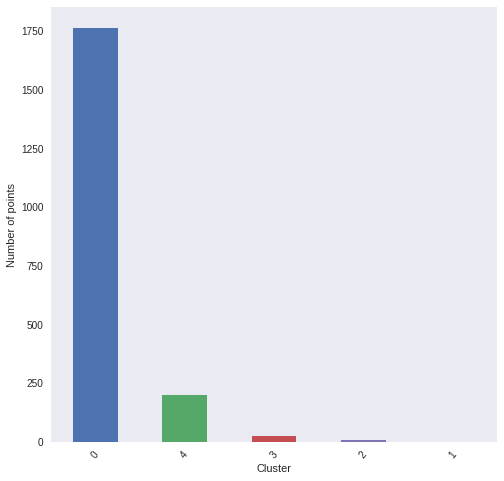

In [0]:
plt.figure(figsize=(8,8))
df2.size().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Cluster")
plt.ylabel("Number of points")
plt.grid()
plt.show()

### [5.5] Wordclouds of clusters obtained in the above section

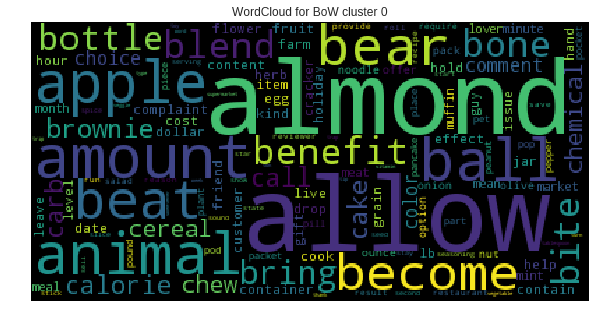

Only few words in cluster  1
****************************************************************************************************
['not']


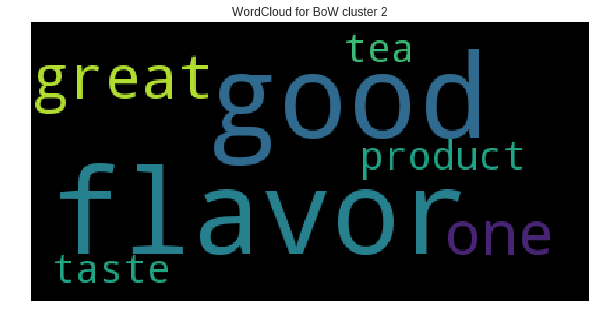

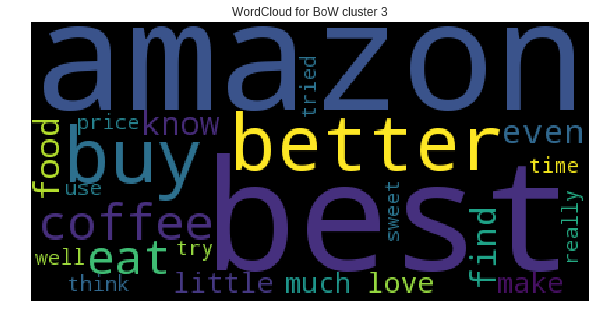

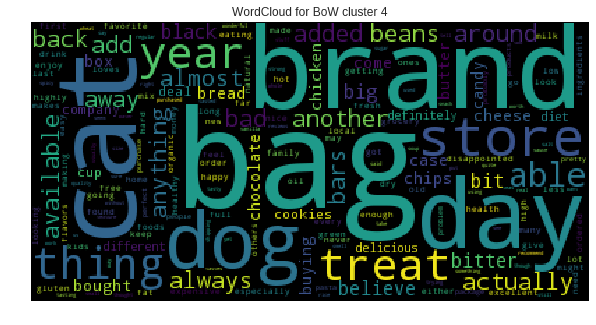

In [0]:
from wordcloud import WordCloud

def show_wordcloud(data,k):
    wordcloud = WordCloud(
        background_color='black'
    ).generate(data)
    
    fig = plt.figure(1, figsize=(10, 10))
    plt.axis('off')
    plt.title('WordCloud for BoW cluster '+str(k))
    plt.imshow(wordcloud)
    plt.show()

for k in range(0,5):    
    try:
        show_wordcloud(
            " ".join(word for word in df2.get_group(k)['words'].values),k
        )
    except ValueError:
        print('Only few words in cluster ',str(k))
        print('*'*100)
        print(df2.get_group(k)['words'].values)

### [5.6] Function that returns most similar words for a given word.

In [0]:
dict_feature={}
for idx,feature in enumerate(tf_idf_vect.get_feature_names()):
    dict_feature[idx]=feature
   

In [0]:
import scipy
def most_similar(word,num=10):
    if (word not in tf_idf_vect.get_feature_names()):
        print('input word not available in vocabulary')
        
    else:    
        idx = tf_idf_vect.vocabulary_[word]
        query_vec = X[idx]
        similarity = []
        words = []
    
        for query_index in range(0,2000):
            if(idx!=query_index):
                check_vec = X[query_index]
                similarity.append(1.0 - scipy.spatial.distance.cosine(check_vec,query_vec))
                words.append(dict_feature[query_index])
        most_similar = sorted(zip(similarity, words),reverse=True)[:num]
        for similarity,word in most_similar:
            print(word,similarity)
            
    

In [0]:
most_similar('good')

awesome 0.928284982525249
amazing 0.9263900261108149
fine 0.9202580605926882
disappointing 0.9182522608097113
ok 0.9164475395482957
terrible 0.9155457253378291
impressed 0.9126991158988127
like 0.9116503071252737
however 0.9087568152679387
gross 0.9085640929093016


In [0]:
most_similar('ball')

rope 0.8859681827530081
toys 0.8559871719168349
jug 0.8461254950447203
toy 0.8313560384454982
bone 0.8303593296830882
play 0.8265595851708757
rawhide 0.8255301317785799
rubber 0.8171587669648119
chewed 0.8160263120410678
pocket 0.8129792600856506


# Conclusions

1. In this assignment we applied Truncated SVD on co-occurence matrix to get the vector representation of words in the vocabulary.
2. We used top 2000 features from the corpus using idf values.
3. To build the co-occurence matrix, we used a window size of 5.
4. The optimal number of dimensions was found to be 140 which preserved close to 98%.
5. We applied Kmeans clustering using elbow method to get optimal number of clusters (5 in our case).
6. We plotted the wordclouds of the words in each cluster.
7. We wrote the function to return 10 most similar words for any given query word.
